###Mount Google Drive
This block mounts Google Drive to access the dataset stored in the user's Google Drive environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install "dask[dataframe]"


INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 16.2 MB/s eta 0:00:00


###Import Libraries and Load Dataset
This block imports essential Python libraries, including pandas, NumPy, Seaborn, Matplotlib, and scikit-learn components for data processing, visualization, and machine learning. It loads the credit risk dataset and checks for duplicates, removing them to ensure data integrity.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/credit_risk_dataset.csv')

# Check for duplicates
dups = df.duplicated()
print(f"Number of duplicate rows: {dups.sum()}")

# Remove duplicates
df.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {df.shape}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Number of duplicate rows: 165
Dataset shape after removing duplicates: (32416, 12)


###Define Target and Train-Test Split
Defines the target variable (loan_status) and separates the dataset into training and testing sets. It ensures that the stratified split maintains the original class distribution, which is crucial for classification tasks.

In [ ]:
# Define target and features
target = 'loan_status'
X, X_test, y, y_test = train_test_split(
    df.drop(target, axis=1),
    df[target],
    test_size=0.2,
    stratify=df[target],
    random_state=0,
    shuffle=True
)

# Check class distribution
print("Class distribution in full dataset:")
print(df[target].value_counts(normalize=True))
print("\nClass distribution in training set:")
print(y.value_counts(normalize=True))


Class distribution in full dataset:
loan_status
0    0.781312
1    0.218688
Name: proportion, dtype: float64

Class distribution in training set:
loan_status
0    0.781313
1    0.218687
Name: proportion, dtype: float64


###Handle Missing Values
Calculates the percentage of missing values for each column. If a column (e.g., loan_percent_income) is deemed irrelevant or has significant missing values, it is dropped from both the training and test datasets.

In [ ]:
# Percentage of missing values in each column
missing_values = np.round(X.isna().sum() * 100 / X.shape[0], 3)
print("Missing Values (%):")
print(missing_values)

# Drop 'loan_percent_income' (if deemed irrelevant)
X.drop('loan_percent_income', axis=1, inplace=True)
X_test.drop('loan_percent_income', axis=1, inplace=True)


Missing Values (%):
person_age                    0.000
person_income                 0.000
person_home_ownership         0.000
person_emp_length             2.800
loan_intent                   0.000
loan_grade                    0.000
loan_amnt                     0.000
loan_int_rate                 9.614
loan_percent_income           0.000
cb_person_default_on_file     0.000
cb_person_cred_hist_length    0.000
dtype: float64


###Examine Categorical Features
Iterates through all columns to identify unique values in each. For categorical features with fewer than 20 unique values, it prints their value distribution (as percentages) to provide insights into data characteristics and potential preprocessing needs.

In [ ]:
# Check unique values and value distributions for categorical columns
for col in X:
    print(f"{col} ---> {X[col].nunique()} unique values")
    if X[col].nunique() < 20:
        print(X[col].value_counts(normalize=True) * 100)
    print()

person_age ---> 58 unique values

person_income ---> 3680 unique values

person_home_ownership ---> 4 unique values
person_home_ownership
RENT        50.320068
MORTGAGE    41.439149
OWN          7.916859
OTHER        0.323924
Name: proportion, dtype: float64

person_emp_length ---> 36 unique values

loan_intent ---> 6 unique values
loan_intent
EDUCATION            19.809502
MEDICAL              18.787598
VENTURE              17.542033
PERSONAL             16.878760
DEBTCONSOLIDATION    15.968687
HOMEIMPROVEMENT      11.013420
Name: proportion, dtype: float64

loan_grade ---> 7 unique values
loan_grade
A    32.932284
B    32.126330
C    19.902052
D    11.121394
E     3.004010
F     0.732685
G     0.181243
Name: proportion, dtype: float64

loan_amnt ---> 710 unique values

loan_int_rate ---> 346 unique values

cb_person_default_on_file ---> 2 unique values
cb_person_default_on_file
N    82.392411
Y    17.607589
Name: proportion, dtype: float64

cb_person_cred_hist_length ---> 29 unique v

###Visualize Numerical Features
Visualizes the distribution of numerical features using histograms with kernel density estimates (KDE). This helps identify potential outliers and assess the need for transformations.

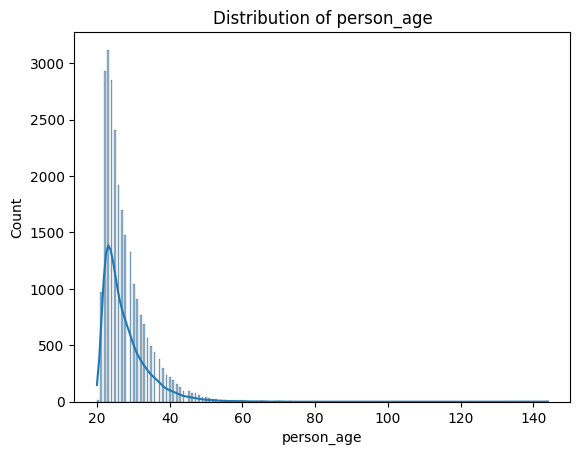

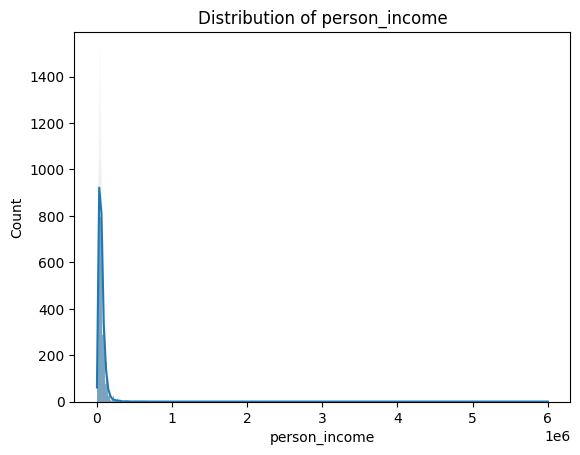

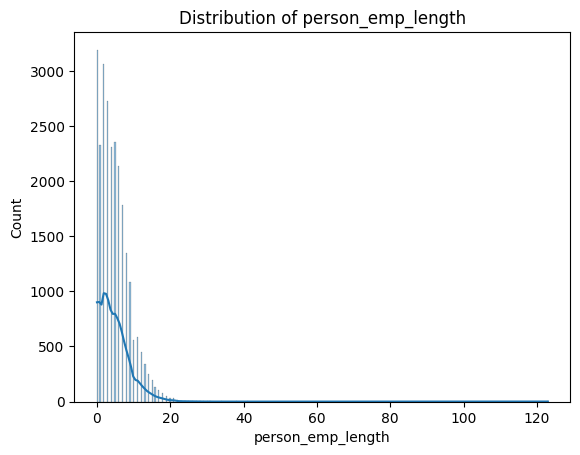

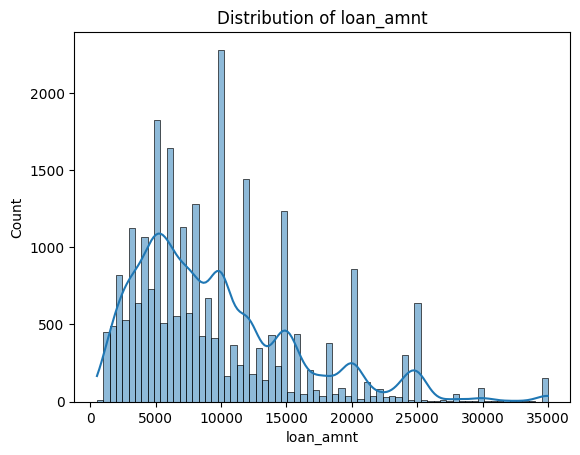

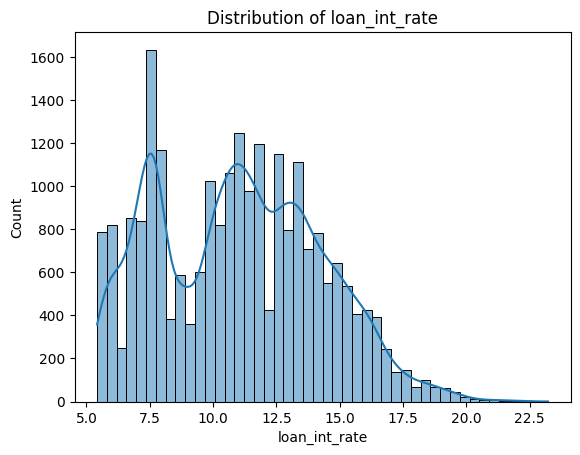

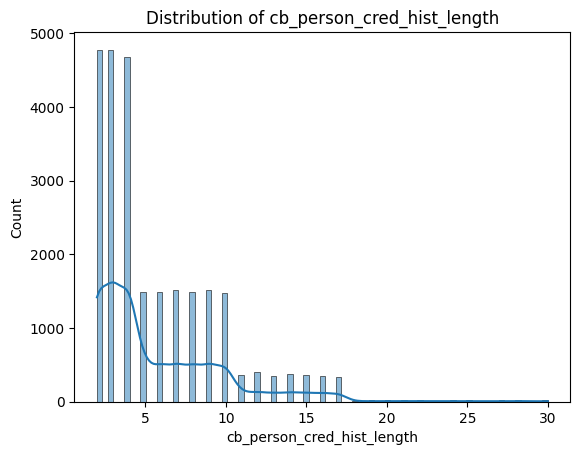

In [ ]:
# Visualize numerical columns
num_cols = [col for col in X if X[col].dtypes != 'O']
for col in num_cols:
    sns.histplot(X[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

###Handle Outliers
Removes outliers from the dataset based on specific criteria for person_age and person_emp_length. The target variable (y) is adjusted to reflect changes in the dataset's index after outlier removal.

In [ ]:
# Restricting outliers
X = X[X['person_age'] < 80]  # Remove rows with 'person_age' >= 80
X = X[(X['person_emp_length'] < 66) | (X['person_emp_length'].isna())]  # Employment length restriction

# Adjust target variable to match index changes
y = y.loc[X.index]

###Handle Outliers
Removes outliers from the dataset based on specific criteria for person_age and person_emp_length. The target variable (y) is adjusted to reflect changes in the dataset's index after outlier removal.

In [ ]:

from sklearn.impute import SimpleImputer

# Define numerical and categorical columns
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical and categorical columns
num_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scale', StandardScaler())  # Scale numerical features
])

cat_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessors in a ColumnTransformer
ct = ColumnTransformer(transformers=[
    ('num_pipe', num_transformer, num_features),
    ('cat_pipe', cat_transformer, cat_features)
])


###Identify Feature Types
Separates columns into categorical and numerical types for targeted preprocessing. This classification is crucial for applying appropriate encoding or scaling techniques during data preparation.

In [ ]:
# Ensure 'ct' is fitted
ct.fit(X)

# Transform the training and test data
X_transformed = ct.transform(X)
X_test_transformed = ct.transform(X_test)

# Extract numerical feature names
from sklearn.compose import make_column_selector as selector
num_feature_names = selector(dtype_include=["int64", "float64"])(X)

# Access the 'cat_pipe' transformer and get feature names
for name, transformer, _ in ct.transformers:
    if name == 'cat_pipe':
        onehot = transformer.named_steps['onehot']  # Access 'OneHotEncoder'
        break

# Extract feature names for categorical features
cat_feature_names = onehot.get_feature_names_out(input_features=cat_features)

# Combine numerical and categorical feature names
transformed_columns = list(num_feature_names) + list(cat_feature_names)

# Convert transformed arrays to DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_columns, index=X.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns, index=X_test.index)

# Display the transformed data
print("Transformed Training Data:")
print(X_transformed_df.head())
print("\nTransformed Test Data:")
print(X_test_transformed_df.head())



NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Verify processed data
print("Processed Training Features:")
print(X.head())

print("\nProcessed Target Values:")
print(y.head())


Processed Training Features:
       person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
21415    0.859806      -0.342792           1.557791   0.061557      -0.332131   
12916   -0.436567       0.375702           0.051702  -0.332954       0.004959   
2938    -0.274520       1.152452           1.306776  -1.043074       0.387426   
19114    0.211620      -0.070929          -0.199313  -1.153538       0.782858   
6057    -0.598614      -0.342792          -0.199313  -0.853709       0.316119   

       cb_person_cred_hist_length  person_home_ownership_OTHER  \
21415                    0.546015                          0.0   
12916                   -0.689909                          0.0   
2938                    -0.442725                          0.0   
19114                    0.051645                          0.0   
6057                    -0.442725                          0.0   

       person_home_ownership_OWN  person_home_ownership_RENT  \
21415                  

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
    }
    if y_proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_test, y_proba)

    print(f"\n{model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))
    print(f"Evaluation Metrics: {metrics}")
    return metrics


In [ ]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=0, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=0, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "SVM (Support Vector Machine)": SVC(probability=True, random_state=0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=0)
}


In [ ]:
# Evaluate each model
results = {}
for model_name, model in models.items():
    results[model_name] = evaluate_model(model, X, y, X_test, y_test)



LogisticRegression:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      5066
           1       0.77      0.45      0.57      1418

    accuracy                           0.85      6484
   macro avg       0.82      0.71      0.74      6484
weighted avg       0.84      0.85      0.84      6484

Evaluation Metrics: {'Accuracy': 0.8505552128315854, 'Precision': 0.7708082026537998, 'Recall': 0.4506346967559944, 'F1 Score': 0.5687583444592791, 'ROC-AUC': 0.8552863833504928}

RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5066
           1       0.93      0.70      0.80      1418

    accuracy                           0.92      6484
   macro avg       0.92      0.84      0.88      6484
weighted avg       0.92      0.92      0.92      6484

Evaluation Metrics: {'Accuracy': 0.9227328809376928, 'Precision': 0.9265116279069767, 'Recall': 0.7023977433004231, 'F1 S

In [ ]:
# Compare model results
results_df = pd.DataFrame(results).T
results_df.sort_values(by="F1 Score", ascending=False, inplace=True)
print("\nModel Comparison:\n", results_df)


Model Comparison:
                               Accuracy  Precision    Recall  F1 Score  \
CatBoost                      0.930444   0.946445  0.722849  0.819672   
XGBoost                       0.927822   0.934186  0.720733  0.813694   
Random Forest                 0.922733   0.926512  0.702398  0.799037   
Gradient Boosting             0.904997   0.893137  0.642454  0.747334   
SVM (Support Vector Machine)  0.900987   0.928256  0.593089  0.723752   
Logistic Regression           0.850555   0.770808  0.450635  0.568758   

                               ROC-AUC  
CatBoost                      0.938679  
XGBoost                       0.940863  
Random Forest                 0.924009  
Gradient Boosting             0.913169  
SVM (Support Vector Machine)  0.888377  
Logistic Regression           0.855286  
